In [37]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
from d2l import torch as d2l

In [38]:

                                # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [39]:
class MNIST_data(Dataset):
    def __init__(self, file_path,
                 transform=transforms.Compose([transforms.ToPILImage(), transforms.Resize(96),transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])):
        df = pd.read_csv(file_path)
        if len(df.columns) == 784:
            # test data
            self.X = df.values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:, 1:].values.reshape((-1, 28, 28)).astype(np.uint8)[:, :, :, None]
            self.y = torch.from_numpy(df.iloc[:, 0].values)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [40]:
trainset = MNIST_data('train.csv')
trainloader = DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)

In [41]:
testset = MNIST_data('test.csv')
testloader = DataLoader(testset,batch_size=128,shuffle=False,num_workers=2)

In [42]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用 GPU 在数据集上计算模型的准确度。"""
    if isinstance(net, nn.Module):
        net.eval()  # 将模型设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT 微调所需
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]
def train_test(net, train_iter, test_iter, num_epochs,device = None):
    """训练并测试参数"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters())

#     optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失总和、训练准确率总和、示例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X= X.to(device)
            y = y.to(device)

#             X = X.cuda()
#             y = y.cuda()
#             print(X.device,y.device)
#             y_hat,test = net(X.to(device))
#             y_hat = y_hat.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))

        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [43]:
def train(net, train_iter,num_epochs,device = None):
    """训练并保存模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters())

#     optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失总和、训练准确率总和、示例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X= X.to(device)
            y = y.to(device)

#             X = X.cuda()
#             y = y.cuda()
#             print(X.device,y.device)
#             y_hat,test = net(X.to(device))
#             y_hat = y_hat.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
    torch.save(net,r'train.pth')
def test(test_iter, device = None,trainfile_dir='gender_Classification.pth'):
    """读取并测试模型"""
    net = torch.load(trainfile_dir)
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    print(test_acc)

In [44]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

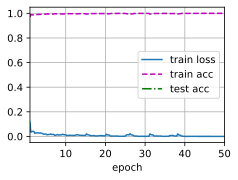

In [51]:
num_epochs=50
# train_test(net,trainloader,testloader, num_epochs,device)
train(net,trainloader, num_epochs,device)

In [52]:
from torch.autograd import Variable
testnet = torch.load('train.pth')
def prediciton(model,data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [53]:
test_pred = prediciton(testnet,testloader)
out_df = pd.DataFrame(np.c_[np.arange(1, len(testset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

<ipython-input-52-9e7714ba1f7e>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True)


In [54]:
out_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [55]:
out_df.to_csv('submission.csv', index=False)